## imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import xgboost as xgb
from sklearn import metrics

In [3]:
PATH = os.getcwd();
PATH

'D:\\Github\\fastai\\courses\\ml1'

In [4]:
df_raw  = pd.read_csv(f'{PATH}\\AV_Mckin\\train_encoded.csv', low_memory= False)
df_test = pd.read_csv(f'{PATH}\\AV_Mckin\\test_encoded.csv', low_memory=False)

## init

In [15]:
df_raw = pd.read_csv(f'{PATH}\\AV_Mckin\\train_ajEneEa.csv', low_memory=False)
df_test = pd.read_csv(f'{PATH}\\AV_Mckin\\test_v2akXPA.csv', low_memory=False)

In [16]:
df_raw.shape, df_test.shape

((43400, 12), (18601, 11))

In [17]:
df_raw.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0


In [18]:
target = df_raw.stroke.values;
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [19]:
# This way we have randomness and are able to reproduce the behaviour within this cell.
np.random.seed(13)
from sklearn.model_selection import KFold

def impact_coding(data, feature, target='y'):
    '''
    In this implementation we get the values and the dictionary as two different steps.
    This is just because initially we were ignoring the dictionary as a result variable.
    
    In this implementation the KFolds use shuffling. If you want reproducibility the cv 
    could be moved to a parameter.
    '''
    n_folds = 10
    n_inner_folds = 5
    impact_coded = pd.Series()
    
    oof_default_mean = data[target].mean() # Gobal mean to use by default (you could further tune this)
    kf = KFold(n_splits=n_folds, shuffle=True)
    oof_mean_cv = pd.DataFrame()
    split = 0
    for infold, oof in kf.split(data[feature]):
            impact_coded_cv = pd.Series()
            kf_inner = KFold(n_splits=n_inner_folds, shuffle=True)
            inner_split = 0
            inner_oof_mean_cv = pd.DataFrame()
            oof_default_inner_mean = data.iloc[infold][target].mean()
            for infold_inner, oof_inner in kf_inner.split(data.iloc[infold]):
                # The mean to apply to the inner oof split (a 1/n_folds % based on the rest)
                oof_mean = data.iloc[infold_inner].groupby(by=feature)[target].mean()
                impact_coded_cv = impact_coded_cv.append(data.iloc[infold].apply(
                            lambda x: oof_mean[x[feature]]
                                      if x[feature] in oof_mean.index
                                      else oof_default_inner_mean
                            , axis=1))

                # Also populate mapping (this has all group -> mean for all inner CV folds)
                inner_oof_mean_cv = inner_oof_mean_cv.join(pd.DataFrame(oof_mean), rsuffix=inner_split, how='outer')
                inner_oof_mean_cv.fillna(value=oof_default_inner_mean, inplace=True)
                inner_split += 1

            # Also populate mapping
            oof_mean_cv = oof_mean_cv.join(pd.DataFrame(inner_oof_mean_cv), rsuffix=split, how='outer')
            oof_mean_cv.fillna(value=oof_default_mean, inplace=True)
            split += 1
            
            impact_coded = impact_coded.append(data.iloc[oof].apply(
                            lambda x: inner_oof_mean_cv.loc[x[feature]].mean()
                                      if x[feature] in inner_oof_mean_cv.index
                                      else oof_default_mean
                            , axis=1))

    return impact_coded, oof_mean_cv.mean(axis=1), oof_default_mean

In [20]:
features = df_raw.columns
numeric_features = []
categorical_features = []

for dtype, feature in zip(df_raw.dtypes, df_raw.columns):
    if dtype == object:
        #print(column)
        #print(train_data[column].describe())
        categorical_features.append(feature)
    else:
        numeric_features.append(feature)
categorical_features

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [22]:
%%time
# Apply the encoding to training and test data, and preserve the mapping
impact_coding_map = {}
for f in categorical_features:
    print("Impact coding for {}".format(f))
    df_raw["impact_encoded_{}".format(f)], impact_coding_mapping, default_coding = impact_coding(df_raw, f,'stroke')
    impact_coding_map[f] = (impact_coding_mapping, default_coding)
    mapping, default_mean = impact_coding_map[f]
    df_test["impact_encoded_{}".format(f)] = df_test.apply(lambda x: mapping[x[f]]
                                                                         if x[f] in mapping
                                                                         else default_mean
                                                               , axis=1)

Impact coding for gender
Impact coding for ever_married
Impact coding for work_type
Impact coding for Residence_type
Impact coding for smoking_status
Wall time: 5min 5s


In [167]:
df_raw.to_csv(f'{PATH}\\AV_Mckin\\train_encoded.csv',index = False)
df_test.to_csv(f'{PATH}\\AV_Mckin\\test_encoded.csv',index = False)

In [175]:
categorical_features_indices1 = np.where(df_raw.dtypes == 'category')[0]

In [176]:
categorical_features_indices1

array([ 1,  5,  6,  7, 10], dtype=int64)

In [33]:
df_raw.fillna(method='bfill',inplace=True)

In [41]:
df_raw.drop('stroke',axis=1,inplace=True)

In [179]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(df_raw, target, train_size=0.8, random_state=1234)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [188]:
#importing library and building model
from catboost import CatBoostClassifier
model=CatBoostClassifier(iterations=1000, depth=12, learning_rate=0.01, loss_function='CrossEntropy',\
                         )
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation))

0:	learn: 0.6738563	test: 0.6739994	best: 0.6739994 (0)	total: 37.1ms	remaining: 37.1s
1:	learn: 0.6551678	test: 0.6554512	best: 0.6554512 (1)	total: 69.9ms	remaining: 34.9s
2:	learn: 0.6370616	test: 0.6374821	best: 0.6374821 (2)	total: 133ms	remaining: 44.3s
3:	learn: 0.6194853	test: 0.6200452	best: 0.6200452 (3)	total: 215ms	remaining: 53.6s
4:	learn: 0.6021464	test: 0.6028698	best: 0.6028698 (4)	total: 250ms	remaining: 49.7s
5:	learn: 0.5857035	test: 0.5865596	best: 0.5865596 (5)	total: 298ms	remaining: 49.3s
6:	learn: 0.5697805	test: 0.5707694	best: 0.5707694 (6)	total: 317ms	remaining: 45s
7:	learn: 0.5543658	test: 0.5554862	best: 0.5554862 (7)	total: 341ms	remaining: 42.2s
8:	learn: 0.5394454	test: 0.5406960	best: 0.5406960 (8)	total: 364ms	remaining: 40.1s
9:	learn: 0.5236859	test: 0.5249893	best: 0.5249893 (9)	total: 544ms	remaining: 53.9s
10:	learn: 0.5097526	test: 0.5111858	best: 0.5111858 (10)	total: 578ms	remaining: 52s
11:	learn: 0.4962037	test: 0.4977545	best: 0.4977545 (

94:	learn: 0.1126218	test: 0.1208184	best: 0.1208184 (94)	total: 6.7s	remaining: 1m 3s
95:	learn: 0.1115510	test: 0.1197845	best: 0.1197845 (95)	total: 6.74s	remaining: 1m 3s
96:	learn: 0.1108163	test: 0.1191022	best: 0.1191022 (96)	total: 6.81s	remaining: 1m 3s
97:	learn: 0.1101019	test: 0.1184398	best: 0.1184398 (97)	total: 6.83s	remaining: 1m 2s
98:	learn: 0.1093209	test: 0.1177131	best: 0.1177131 (98)	total: 6.87s	remaining: 1m 2s
99:	learn: 0.1085727	test: 0.1170199	best: 0.1170199 (99)	total: 6.93s	remaining: 1m 2s
100:	learn: 0.1079177	test: 0.1164152	best: 0.1164152 (100)	total: 6.95s	remaining: 1m 1s
101:	learn: 0.1072200	test: 0.1157661	best: 0.1157661 (101)	total: 7.09s	remaining: 1m 2s
102:	learn: 0.1065167	test: 0.1151161	best: 0.1151161 (102)	total: 7.14s	remaining: 1m 2s
103:	learn: 0.1055718	test: 0.1142073	best: 0.1142073 (103)	total: 7.22s	remaining: 1m 2s
104:	learn: 0.1047498	test: 0.1134175	best: 0.1134175 (104)	total: 7.31s	remaining: 1m 2s
105:	learn: 0.1041669	t

186:	learn: 0.0785715	test: 0.0894692	best: 0.0894692 (186)	total: 13.7s	remaining: 59.4s
187:	learn: 0.0784749	test: 0.0893838	best: 0.0893838 (187)	total: 13.7s	remaining: 59.3s
188:	learn: 0.0784309	test: 0.0893562	best: 0.0893562 (188)	total: 13.8s	remaining: 59s
189:	learn: 0.0783716	test: 0.0893128	best: 0.0893128 (189)	total: 13.8s	remaining: 58.8s
190:	learn: 0.0782588	test: 0.0892136	best: 0.0892136 (190)	total: 13.9s	remaining: 58.7s
191:	learn: 0.0781435	test: 0.0891121	best: 0.0891121 (191)	total: 14s	remaining: 59.1s
192:	learn: 0.0779856	test: 0.0889622	best: 0.0889622 (192)	total: 14.1s	remaining: 59.1s
193:	learn: 0.0778036	test: 0.0888403	best: 0.0888403 (193)	total: 14.3s	remaining: 59.6s
194:	learn: 0.0777052	test: 0.0887526	best: 0.0887526 (194)	total: 14.4s	remaining: 59.4s
195:	learn: 0.0776438	test: 0.0887083	best: 0.0887083 (195)	total: 14.4s	remaining: 59.2s
196:	learn: 0.0775521	test: 0.0886236	best: 0.0886236 (196)	total: 14.5s	remaining: 59.1s
197:	learn: 0.

277:	learn: 0.0726385	test: 0.0854240	best: 0.0854240 (277)	total: 31.8s	remaining: 1m 22s
278:	learn: 0.0725772	test: 0.0853972	best: 0.0853972 (278)	total: 32.5s	remaining: 1m 24s
279:	learn: 0.0725346	test: 0.0853840	best: 0.0853840 (279)	total: 32.7s	remaining: 1m 24s
280:	learn: 0.0724894	test: 0.0853636	best: 0.0853636 (280)	total: 33s	remaining: 1m 24s
281:	learn: 0.0724469	test: 0.0853587	best: 0.0853587 (281)	total: 33.4s	remaining: 1m 24s
282:	learn: 0.0724234	test: 0.0853358	best: 0.0853358 (282)	total: 33.4s	remaining: 1m 24s
283:	learn: 0.0723898	test: 0.0853422	best: 0.0853358 (282)	total: 34.3s	remaining: 1m 26s
284:	learn: 0.0723292	test: 0.0853276	best: 0.0853276 (284)	total: 34.6s	remaining: 1m 26s
285:	learn: 0.0722624	test: 0.0853163	best: 0.0853163 (285)	total: 35.3s	remaining: 1m 28s
286:	learn: 0.0722543	test: 0.0853120	best: 0.0853120 (286)	total: 35.4s	remaining: 1m 27s
287:	learn: 0.0721468	test: 0.0852799	best: 0.0852799 (287)	total: 36.1s	remaining: 1m 29s
2

368:	learn: 0.0693138	test: 0.0845958	best: 0.0845958 (368)	total: 1m 4s	remaining: 1m 50s
369:	learn: 0.0692605	test: 0.0845851	best: 0.0845851 (369)	total: 1m 4s	remaining: 1m 50s
370:	learn: 0.0692461	test: 0.0845777	best: 0.0845777 (370)	total: 1m 5s	remaining: 1m 50s
371:	learn: 0.0692202	test: 0.0845714	best: 0.0845714 (371)	total: 1m 5s	remaining: 1m 50s
372:	learn: 0.0691919	test: 0.0845742	best: 0.0845714 (371)	total: 1m 6s	remaining: 1m 51s
373:	learn: 0.0691371	test: 0.0845681	best: 0.0845681 (373)	total: 1m 6s	remaining: 1m 51s
374:	learn: 0.0690961	test: 0.0845688	best: 0.0845681 (373)	total: 1m 7s	remaining: 1m 52s
375:	learn: 0.0690751	test: 0.0845574	best: 0.0845574 (375)	total: 1m 7s	remaining: 1m 52s
376:	learn: 0.0689768	test: 0.0845485	best: 0.0845485 (376)	total: 1m 8s	remaining: 1m 53s
377:	learn: 0.0689755	test: 0.0845468	best: 0.0845468 (377)	total: 1m 8s	remaining: 1m 52s
378:	learn: 0.0689644	test: 0.0845354	best: 0.0845354 (378)	total: 1m 8s	remaining: 1m 52s

458:	learn: 0.0671802	test: 0.0844181	best: 0.0843661 (442)	total: 1m 36s	remaining: 1m 53s
459:	learn: 0.0671579	test: 0.0844239	best: 0.0843661 (442)	total: 1m 36s	remaining: 1m 53s
460:	learn: 0.0671481	test: 0.0844255	best: 0.0843661 (442)	total: 1m 37s	remaining: 1m 53s
461:	learn: 0.0671280	test: 0.0844288	best: 0.0843661 (442)	total: 1m 37s	remaining: 1m 53s
462:	learn: 0.0671168	test: 0.0844225	best: 0.0843661 (442)	total: 1m 37s	remaining: 1m 52s
463:	learn: 0.0670844	test: 0.0844250	best: 0.0843661 (442)	total: 1m 38s	remaining: 1m 53s
464:	learn: 0.0670571	test: 0.0844208	best: 0.0843661 (442)	total: 1m 38s	remaining: 1m 53s
465:	learn: 0.0669860	test: 0.0844126	best: 0.0843661 (442)	total: 1m 39s	remaining: 1m 54s
466:	learn: 0.0669530	test: 0.0844231	best: 0.0843661 (442)	total: 1m 40s	remaining: 1m 54s
467:	learn: 0.0669354	test: 0.0844156	best: 0.0843661 (442)	total: 1m 40s	remaining: 1m 54s
468:	learn: 0.0669346	test: 0.0844145	best: 0.0843661 (442)	total: 1m 40s	remain

548:	learn: 0.0648622	test: 0.0844103	best: 0.0843661 (442)	total: 2m 16s	remaining: 1m 52s
549:	learn: 0.0648021	test: 0.0844121	best: 0.0843661 (442)	total: 2m 17s	remaining: 1m 52s
550:	learn: 0.0647620	test: 0.0844098	best: 0.0843661 (442)	total: 2m 18s	remaining: 1m 52s
551:	learn: 0.0647022	test: 0.0844086	best: 0.0843661 (442)	total: 2m 19s	remaining: 1m 52s
552:	learn: 0.0647015	test: 0.0844075	best: 0.0843661 (442)	total: 2m 19s	remaining: 1m 52s
553:	learn: 0.0647011	test: 0.0844060	best: 0.0843661 (442)	total: 2m 19s	remaining: 1m 52s
554:	learn: 0.0646931	test: 0.0844048	best: 0.0843661 (442)	total: 2m 19s	remaining: 1m 51s
555:	learn: 0.0646929	test: 0.0844032	best: 0.0843661 (442)	total: 2m 19s	remaining: 1m 51s
556:	learn: 0.0646614	test: 0.0844088	best: 0.0843661 (442)	total: 2m 20s	remaining: 1m 51s
557:	learn: 0.0646561	test: 0.0844048	best: 0.0843661 (442)	total: 2m 20s	remaining: 1m 51s
558:	learn: 0.0646440	test: 0.0844095	best: 0.0843661 (442)	total: 2m 20s	remain

638:	learn: 0.0633144	test: 0.0843637	best: 0.0843342 (623)	total: 2m 52s	remaining: 1m 37s
639:	learn: 0.0633110	test: 0.0843607	best: 0.0843342 (623)	total: 2m 52s	remaining: 1m 37s
640:	learn: 0.0633107	test: 0.0843595	best: 0.0843342 (623)	total: 2m 52s	remaining: 1m 36s
641:	learn: 0.0632600	test: 0.0843686	best: 0.0843342 (623)	total: 2m 53s	remaining: 1m 36s
642:	learn: 0.0632518	test: 0.0843648	best: 0.0843342 (623)	total: 2m 53s	remaining: 1m 36s
643:	learn: 0.0632309	test: 0.0843640	best: 0.0843342 (623)	total: 2m 54s	remaining: 1m 36s
644:	learn: 0.0632077	test: 0.0843602	best: 0.0843342 (623)	total: 2m 54s	remaining: 1m 36s
645:	learn: 0.0631907	test: 0.0843609	best: 0.0843342 (623)	total: 2m 55s	remaining: 1m 36s
646:	learn: 0.0631736	test: 0.0843620	best: 0.0843342 (623)	total: 2m 55s	remaining: 1m 35s
647:	learn: 0.0631734	test: 0.0843606	best: 0.0843342 (623)	total: 2m 55s	remaining: 1m 35s
648:	learn: 0.0631366	test: 0.0843689	best: 0.0843342 (623)	total: 2m 56s	remain

728:	learn: 0.0619474	test: 0.0843950	best: 0.0843342 (623)	total: 3m 30s	remaining: 1m 18s
729:	learn: 0.0619469	test: 0.0843939	best: 0.0843342 (623)	total: 3m 30s	remaining: 1m 17s
730:	learn: 0.0619462	test: 0.0843923	best: 0.0843342 (623)	total: 3m 30s	remaining: 1m 17s
731:	learn: 0.0619394	test: 0.0843951	best: 0.0843342 (623)	total: 3m 30s	remaining: 1m 17s
732:	learn: 0.0619304	test: 0.0844013	best: 0.0843342 (623)	total: 3m 30s	remaining: 1m 16s
733:	learn: 0.0619300	test: 0.0844002	best: 0.0843342 (623)	total: 3m 30s	remaining: 1m 16s
734:	learn: 0.0619213	test: 0.0843978	best: 0.0843342 (623)	total: 3m 31s	remaining: 1m 16s
735:	learn: 0.0619038	test: 0.0843980	best: 0.0843342 (623)	total: 3m 32s	remaining: 1m 16s
736:	learn: 0.0618788	test: 0.0843998	best: 0.0843342 (623)	total: 3m 33s	remaining: 1m 16s
737:	learn: 0.0618454	test: 0.0844013	best: 0.0843342 (623)	total: 3m 33s	remaining: 1m 15s
738:	learn: 0.0618391	test: 0.0844016	best: 0.0843342 (623)	total: 3m 34s	remain

819:	learn: 0.0602157	test: 0.0845101	best: 0.0843342 (623)	total: 4m 14s	remaining: 55.9s
820:	learn: 0.0602124	test: 0.0845114	best: 0.0843342 (623)	total: 4m 14s	remaining: 55.5s
821:	learn: 0.0601845	test: 0.0845127	best: 0.0843342 (623)	total: 4m 15s	remaining: 55.3s
822:	learn: 0.0601631	test: 0.0845180	best: 0.0843342 (623)	total: 4m 15s	remaining: 55s
823:	learn: 0.0601543	test: 0.0845222	best: 0.0843342 (623)	total: 4m 15s	remaining: 54.6s
824:	learn: 0.0601513	test: 0.0845217	best: 0.0843342 (623)	total: 4m 15s	remaining: 54.3s
825:	learn: 0.0601503	test: 0.0845198	best: 0.0843342 (623)	total: 4m 16s	remaining: 53.9s
826:	learn: 0.0601379	test: 0.0845203	best: 0.0843342 (623)	total: 4m 17s	remaining: 53.8s
827:	learn: 0.0601329	test: 0.0845214	best: 0.0843342 (623)	total: 4m 17s	remaining: 53.5s
828:	learn: 0.0601273	test: 0.0845159	best: 0.0843342 (623)	total: 4m 17s	remaining: 53.1s
829:	learn: 0.0601236	test: 0.0845171	best: 0.0843342 (623)	total: 4m 17s	remaining: 52.7s
8

910:	learn: 0.0580889	test: 0.0846346	best: 0.0843342 (623)	total: 5m 5s	remaining: 29.8s
911:	learn: 0.0580885	test: 0.0846327	best: 0.0843342 (623)	total: 5m 5s	remaining: 29.5s
912:	learn: 0.0580702	test: 0.0846321	best: 0.0843342 (623)	total: 5m 6s	remaining: 29.2s
913:	learn: 0.0579818	test: 0.0846403	best: 0.0843342 (623)	total: 5m 6s	remaining: 28.9s
914:	learn: 0.0579680	test: 0.0846397	best: 0.0843342 (623)	total: 5m 7s	remaining: 28.6s
915:	learn: 0.0579128	test: 0.0846373	best: 0.0843342 (623)	total: 5m 8s	remaining: 28.3s
916:	learn: 0.0579070	test: 0.0846358	best: 0.0843342 (623)	total: 5m 8s	remaining: 28s
917:	learn: 0.0578692	test: 0.0846316	best: 0.0843342 (623)	total: 5m 9s	remaining: 27.7s
918:	learn: 0.0578489	test: 0.0846226	best: 0.0843342 (623)	total: 5m 10s	remaining: 27.4s
919:	learn: 0.0578298	test: 0.0846341	best: 0.0843342 (623)	total: 5m 11s	remaining: 27.1s
920:	learn: 0.0577740	test: 0.0846395	best: 0.0843342 (623)	total: 5m 12s	remaining: 26.8s
921:	lear

In [189]:
df_test.fillna(method='ffill', inplace=True)

In [190]:
prediction_proba = model.predict_proba(df_test)

In [191]:
prediction_proba[:,1]

array([ 0.0757 ,  0.12079,  0.00022, ...,  0.08743,  0.00652,  0.00109])

In [33]:
def make_submission(probs):
    sample = pd.read_csv(f'{PATH}\\AV_Mckin\\sample_submission_1.csv')
    submit = sample.copy()
    submit['stroke'] = probs
    return submit

In [34]:
sample = pd.read_csv(f'{PATH}\\AV_Mckin\\sample_submission_1.csv')

In [ ]:
submit = make_submission(preds_xgb)

In [ ]:
submit.head(2)

In [ ]:
submit.to_csv(f'{PATH}\\AV_Mckin\\xgb.csv', index=False)

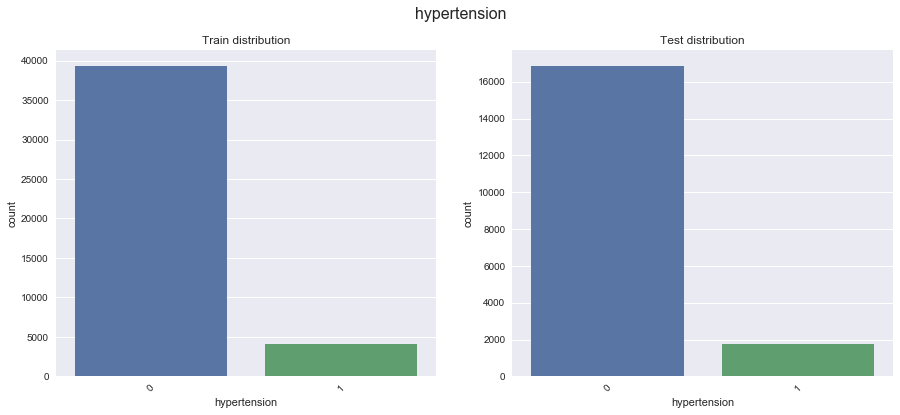

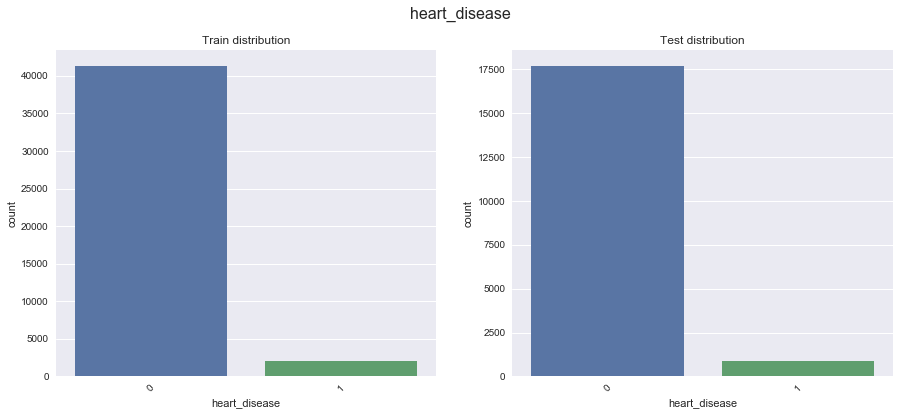

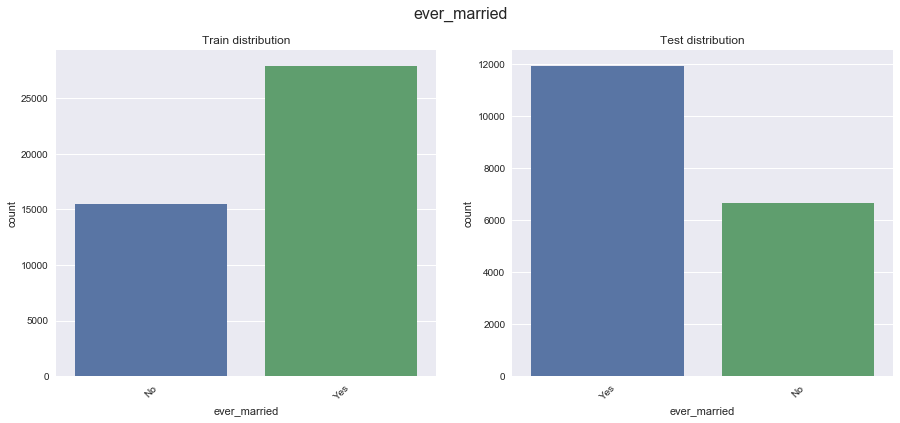

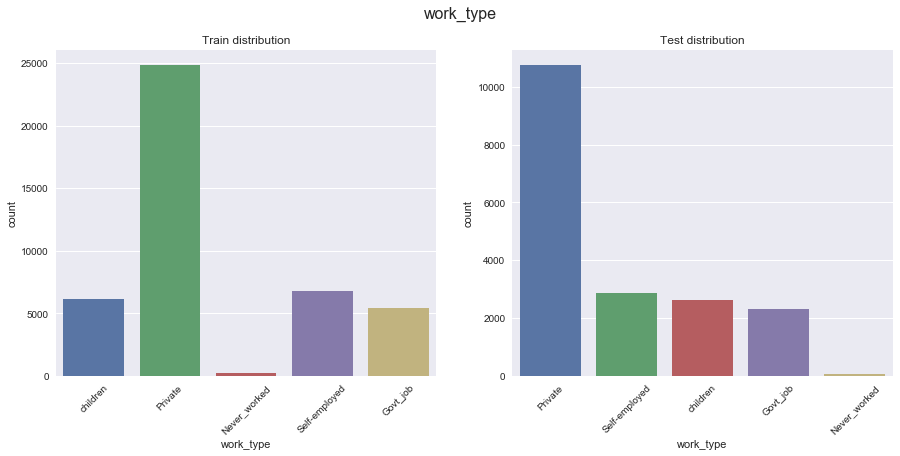

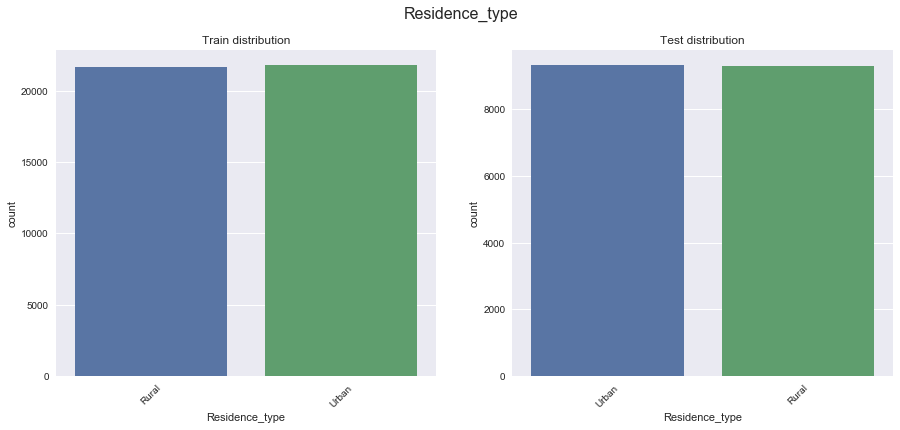

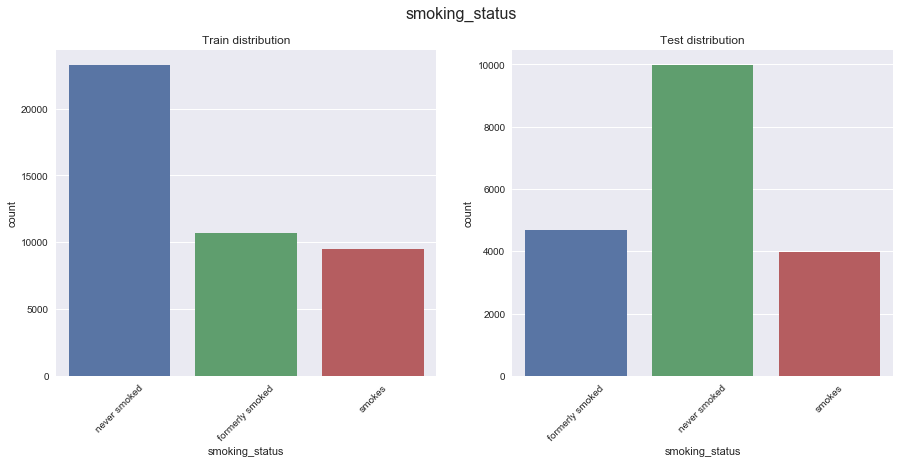

In [66]:
sns.set()
feature_list = ['hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status'] 
for  column_name in feature_list: 
    fig , (ax1,ax2) = plt.subplots(1,2,figsize = ( 15 , 6 )) 
    fig.suptitle(column_name,fontsize=16) 
    sns.countplot(df_raw[column_name],ax=ax1)
    ax1.set_title("Train distribution") 
    for tick in ax1.get_xticklabels(): 
        tick.set_rotation(45)
    sns.countplot(df_test[column_name],ax=ax2,) 
    ax2.set_title("Test distribution")
    for tick in ax2.get_xticklabels(): 
        tick.set_rotation(45)

In [88]:
df_raw['y'] = y

In [150]:
df_raw['is_age>40'] = np.where(df_raw['age']>=40,1,0)
df_test['is_age>40'] = np.where(df_test['age']>=40,1,0)

df_raw['healthy'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('bmi>=18.5 & bmi<=25').index
df_raw.iloc[my_query, -1] = 1

df_raw['under_weight'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('bmi<=18.5').index
df_raw.iloc[my_query, -1] = 1

df_raw['over_weight'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('bmi>25. & bmi<=29.9').index
df_raw.iloc[my_query, -1] = 1

df_raw['obsese'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('bmi>=30').index
df_raw.iloc[my_query, -1] = 1

df_raw['normal_glucose'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('avg_glucose_level<=140').index
df_raw.iloc[my_query, -1] = 1

df_raw['pre_diabetes'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('avg_glucose_level>140 & avg_glucose_level<=199.').index
df_raw.iloc[my_query, -1] = 1

df_raw['diabetes'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('avg_glucose_level>=200').index
df_raw.iloc[my_query, -1] = 1

df_test['normal_glucose'] = np.zeros(df_test.shape[0])
my_query = df_test.query('avg_glucose_level<=140').index
df_test.iloc[my_query, -1] = 1

df_test['pre_diabetes'] = np.zeros(df_test.shape[0])
my_query = df_test.query('avg_glucose_level>140 & avg_glucose_level<=199.').index
df_test.iloc[my_query, -1] = 1

df_test['diabetes'] = np.zeros(df_test.shape[0])
my_query = df_test.query('avg_glucose_level>=200').index
df_test.iloc[my_query, -1] = 1

df_test['healthy'] = np.zeros(df_test.shape[0])
my_query = df_test.query('bmi>=18.5 & bmi<=25').index
df_test.iloc[my_query, -1] = 1

df_test['under_weight'] = np.zeros(df_test.shape[0])
my_query = df_test.query('bmi<=18.5').index
df_test.iloc[my_query, -1] = 1

df_test['over_weight'] = np.zeros(df_test.shape[0])
my_query = df_test.query('bmi>25. & bmi<=29.9').index
df_test.iloc[my_query, -1] = 1

df_test['obsese'] = np.zeros(df_test.shape[0])
my_query = df_test.query('bmi>=30').index
df_test.iloc[my_query, -1] = 1

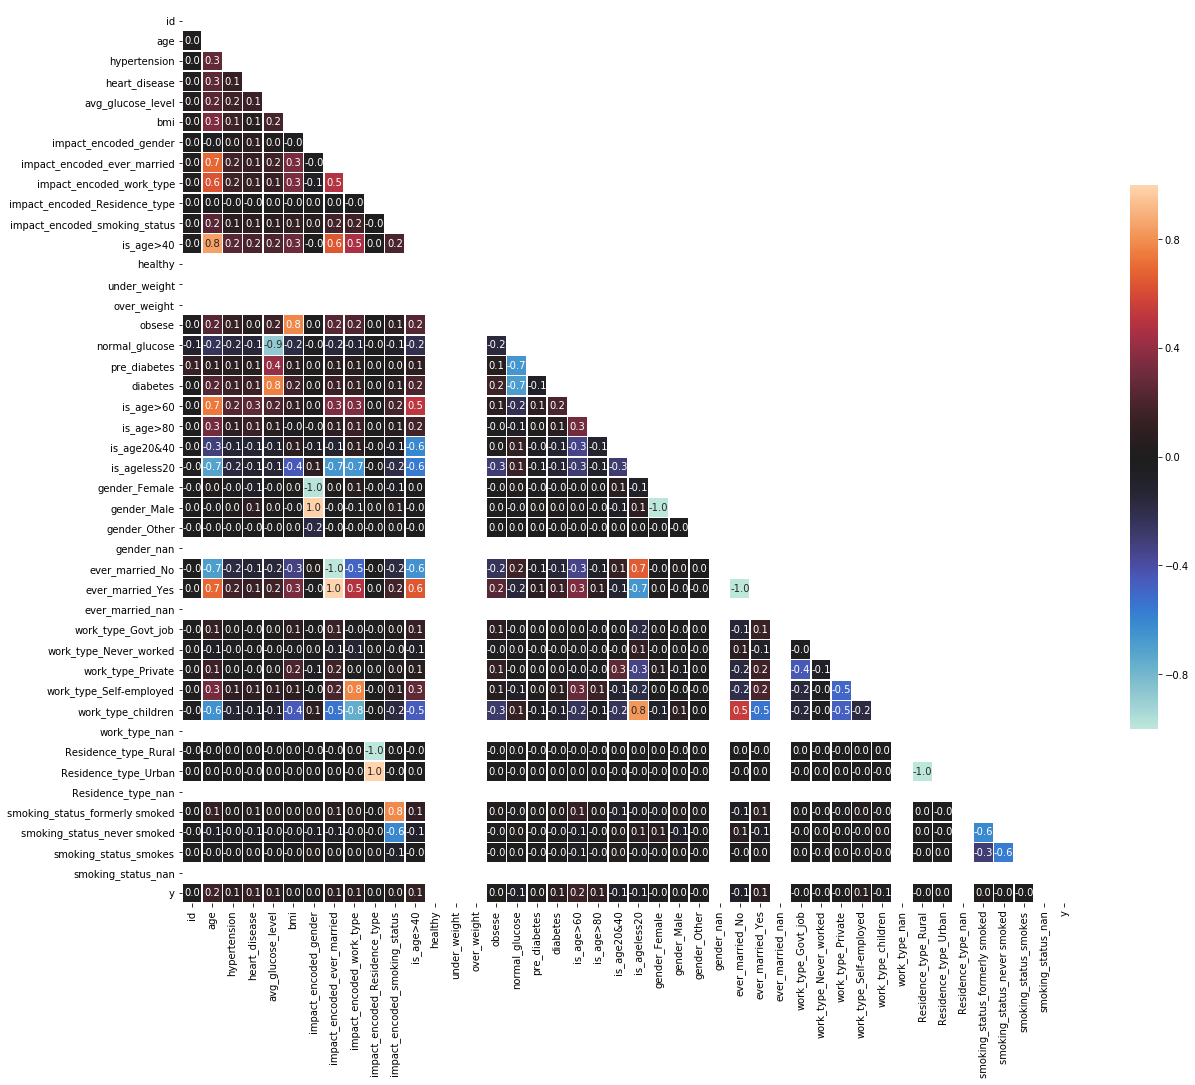

In [115]:
df_train['y'] = y
corr = df_train.corr()

# Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.1f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

df_train.drop('y',axis=1,inplace=True)

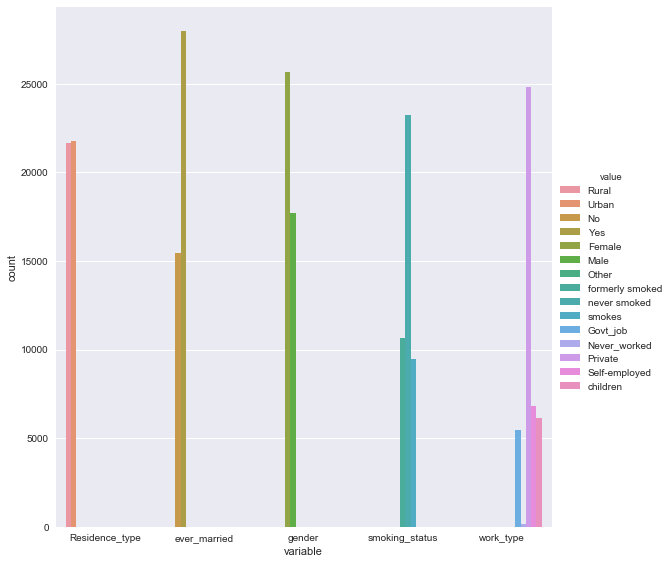

In [119]:
df_uniques = pd.melt(frame=df_raw, value_vars=['gender','ever_married', 
                                           'work_type', 'Residence_type', 'smoking_status'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 
                                              'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.factorplot(x='variable', y='count', hue='value', 
               data=df_uniques, kind='bar',size=8);

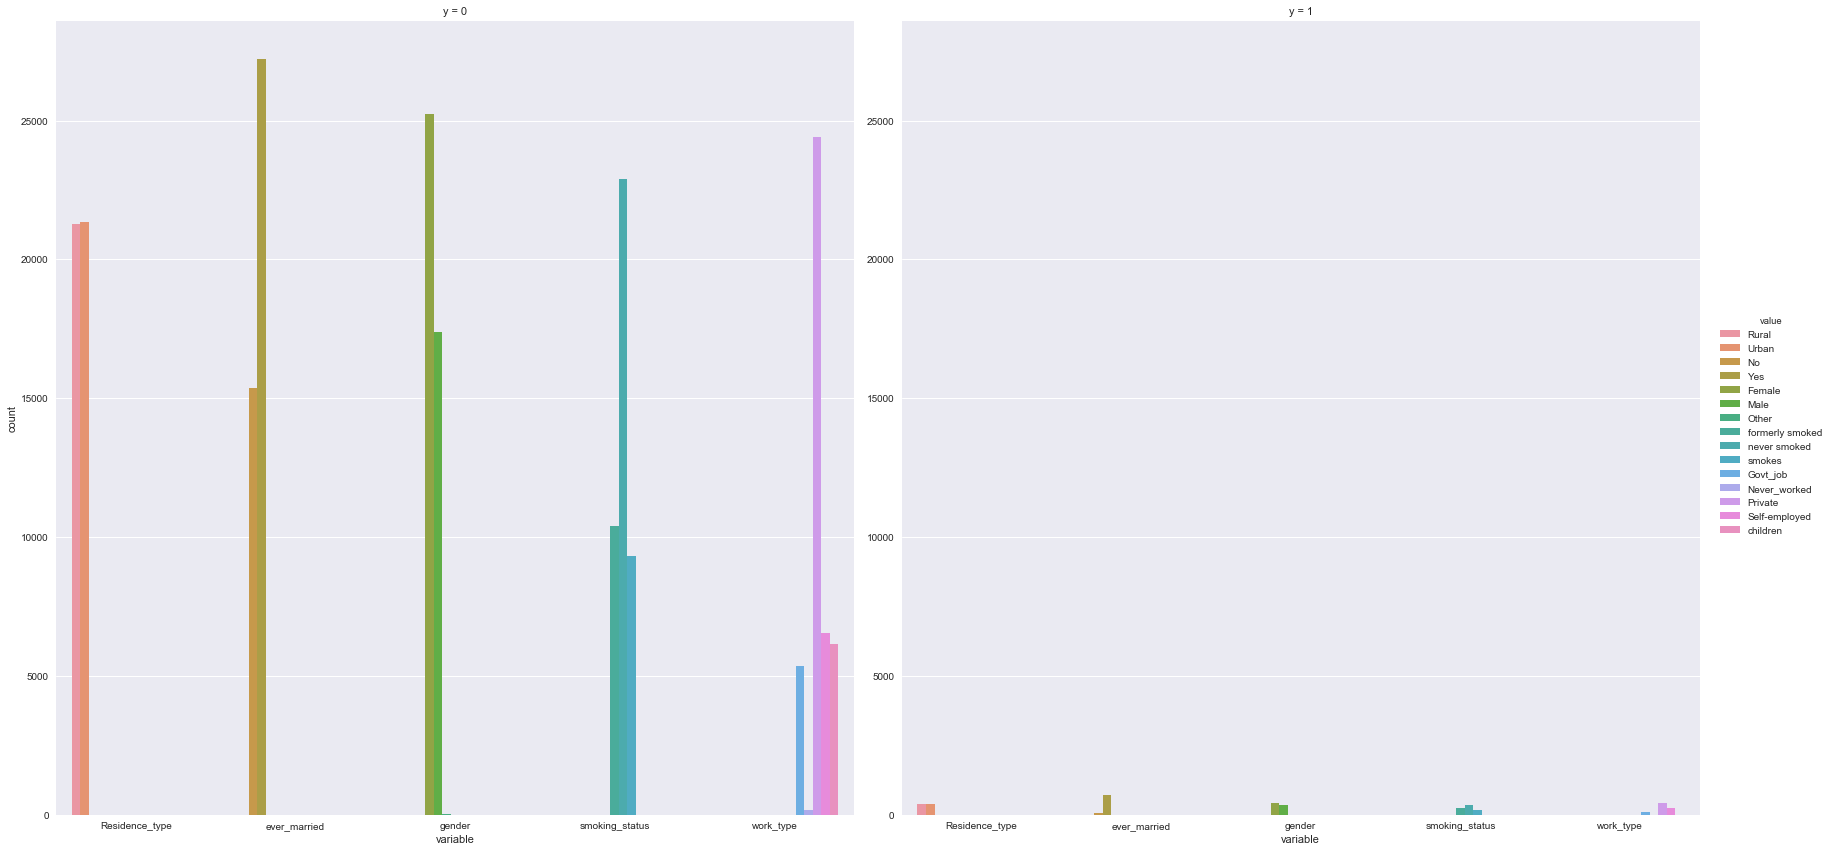

In [121]:
df_uniques = pd.melt(frame=df_raw, value_vars=['gender','ever_married', 
                                           'work_type', 'Residence_type', 'smoking_status'], id_vars=['y'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 
                                              'value', 'y'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.factorplot(x='variable', y='count', hue='value', 
               col= 'y', data=df_uniques, kind='bar',size=12);

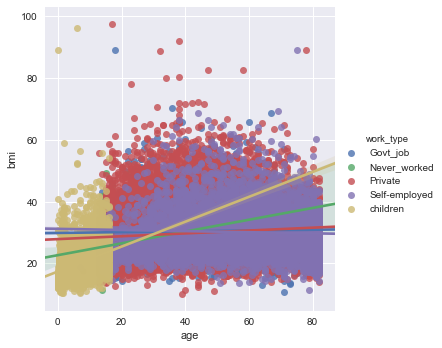

In [109]:
plt.figure(figsize=(15,15))
sns.lmplot(x='age', y='bmi', hue='work_type', data=df_raw);

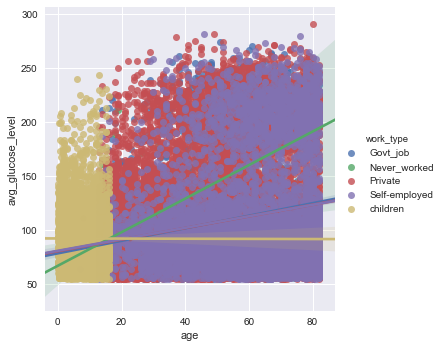

In [111]:
plt.figure(figsize=(20,20))
sns.lmplot(x='age', y='avg_glucose_level', hue='work_type', data=df_raw);

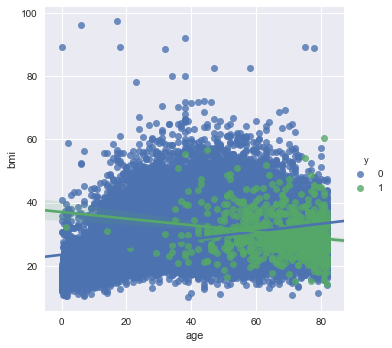

In [89]:
sns.lmplot(x='age', y='bmi', hue='y', data=df_raw,)

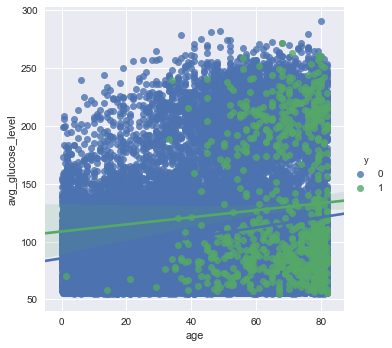

In [102]:
sns.lmplot(x='age', y='avg_glucose_level', hue='y', data=df_raw,)

## gbm

In [67]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [77]:
train_cats(df_raw)
train_cats(df_test)
df_raw['y'] = target
df_test['y'] = target[:18601]
df_raw1, y, nas = proc_df(df_raw, 'y', max_n_cat=10,)
df_test1, _, _ = proc_df(df_test, 'y', na_dict=nas)
df_raw.drop('y', axis=1, inplace=True)
df_test.drop('y', axis=1, inplace=True)

In [79]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], target)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], target, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(target , dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(target , dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        plt.figure(figsize=(20,20))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9825
AUC Score (Train): 0.888989
CV Score : Mean - 0.8425214 | Std - 0.01152719 | Min - 0.8319186 | Max - 0.8631636


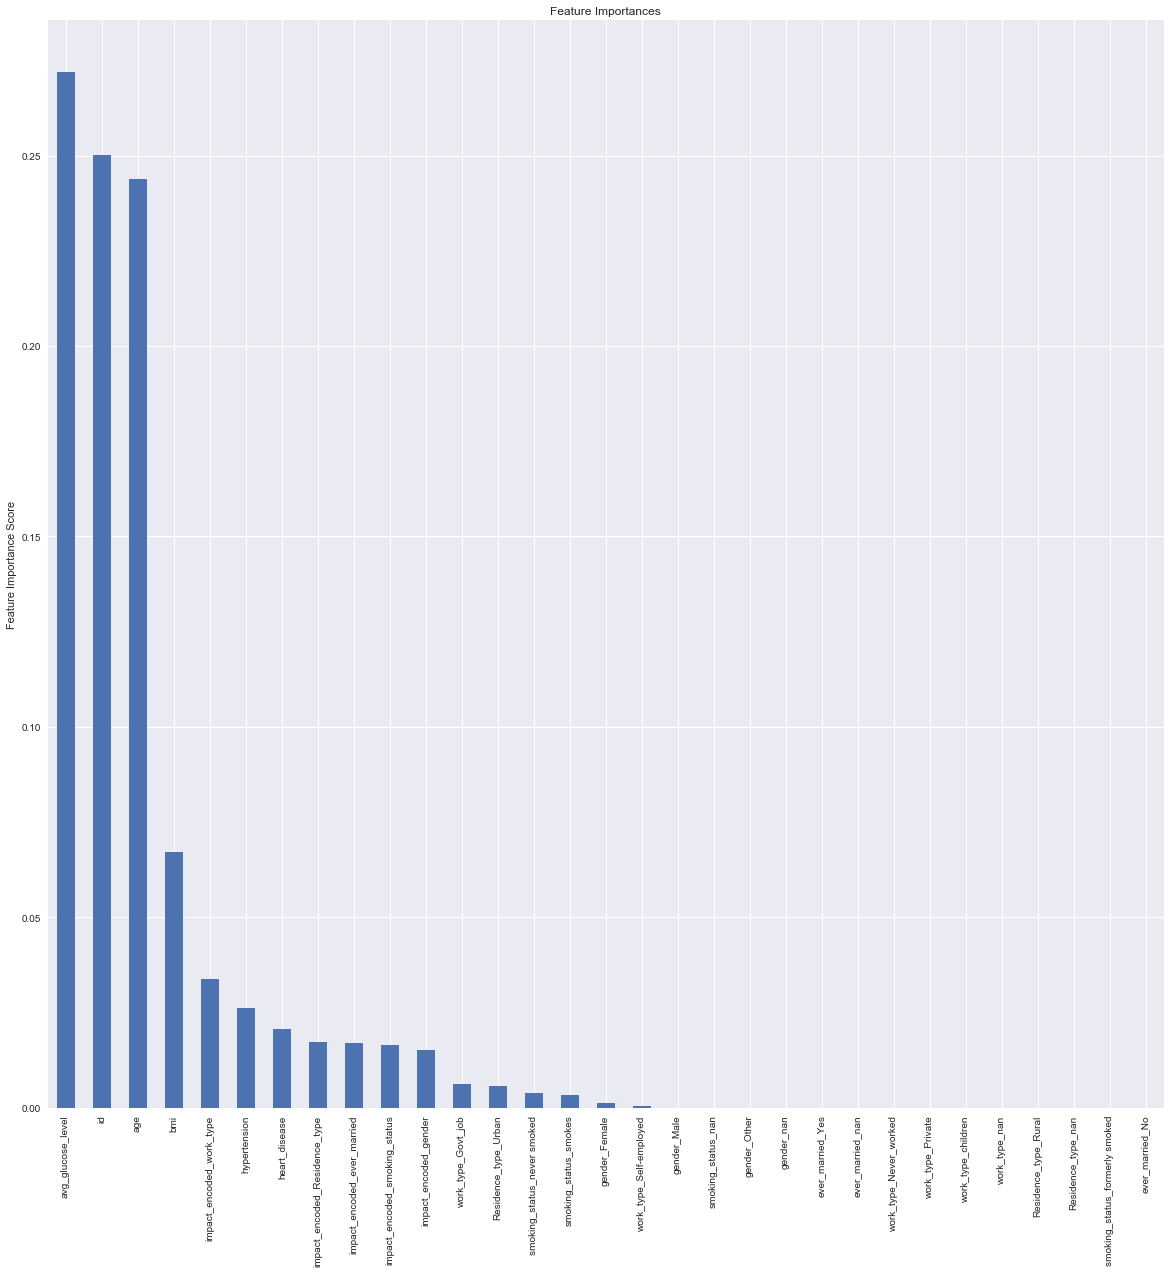

In [80]:
#Choose all predictors except target & IDcols
predictors = df_raw1.columns
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, df_raw1, predictors)

In [81]:
param_test1 = {'n_estimators':[20, 30, 40, 50, 60, 70, 80, 90]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, min_samples_split=500,
                        min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
                        param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(df_raw1[predictors], y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [82]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.83732, std: 0.01340, params: {'n_estimators': 20},
  mean: 0.83928, std: 0.01163, params: {'n_estimators': 30},
  mean: 0.83849, std: 0.01136, params: {'n_estimators': 40},
  mean: 0.83853, std: 0.01185, params: {'n_estimators': 50},
  mean: 0.83919, std: 0.01194, params: {'n_estimators': 60},
  mean: 0.83960, std: 0.01208, params: {'n_estimators': 70},
  mean: 0.83813, std: 0.01249, params: {'n_estimators': 80},
  mean: 0.83776, std: 0.01266, params: {'n_estimators': 90}],
 {'n_estimators': 70},
 0.8395959015215009)

In [83]:
## Test 2
param_test2 = {'max_depth':[5, 7, 9, 11, 13, 15] ,'min_samples_split': [200, 400, 600, 800, 1000]}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=70, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(df_raw1[predictors], y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.83997, std: 0.01458, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.84058, std: 0.01308, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: 0.84120, std: 0.01390, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: 0.84177, std: 0.01324, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: 0.84167, std: 0.01295, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: 0.83777, std: 0.01338, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: 0.84019, std: 0.01100, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: 0.83926, std: 0.01416, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: 0.84049, std: 0.01288, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: 0.84180, std: 0.01486, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: 0.83253, std: 0.01122, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: 0.83926, std: 0.01171, params: {'max_depth': 9, 'min_samples_split': 400},
  

In [84]:
#test 3
param_test3 = {'min_samples_split': [800, 1000, 1200, 1600] , 'min_samples_leaf': [30, 40, 70]}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=70,\
                                    max_depth=7,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

In [85]:
gsearch3.fit(df_raw1[predictors], y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=7,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=70,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [800, 1000, 1200, 1600], 'min_samples_leaf': [30, 40, 70]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

## fast.ai RF

In [197]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [29]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df_raw.drop('stroke', axis=1), df_raw.stroke)

ValueError: could not convert string to float: 'never smoked'

In [199]:
train_cats(df_raw)

In [10]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Residence_type       0.000000
age                  0.000000
avg_glucose_level    0.000000
bmi                  0.033687
ever_married         0.000000
gender               0.000000
heart_disease        0.000000
hypertension         0.000000
id                   0.000000
smoking_status       0.306267
stroke               0.000000
work_type            0.000000
dtype: float64

In [201]:
df_raw['stroke'] = y

In [202]:
df, y, nas = proc_df(df_raw, 'stroke', max_n_cat= 20,)

In [203]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.8028024180806016

In [37]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 18601  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((24799, 27), (24799,), (18601, 27))

In [38]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [39]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 391 ms
[0.05957292526588625, 0.14113786444375237, 0.79313164863241237, -0.078959044122826505]


In [40]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.12734843467992937, 0.1332539907026114, 0.05467003736538123, 0.038214280483870766]


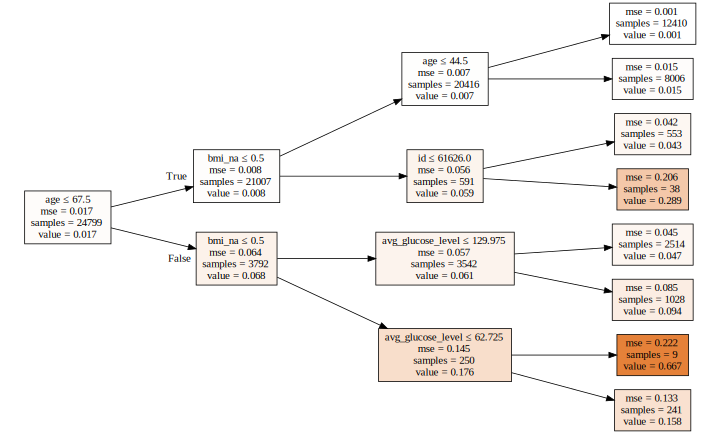

In [43]:
draw_tree(m.estimators_[0], df, precision=3)

In [44]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.0, 0.19021264545741703, 1.0, -0.95973183465485201]


In [45]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 0.]), 0.0, 0)

In [46]:
preds.shape

(1, 18601)

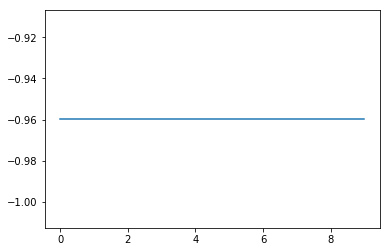

In [47]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [48]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.053935037458556316, 0.13877986749122004, 0.83043423624976986, -0.043207769828658593]


In [49]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.05065202509550886, 0.13635991787486, 0.85044882563614643, -0.0071434625891337866]


In [50]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.04932920584416187, 0.13539700042187303, 0.85815812991186269, 0.007030377983202718]


In [51]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.05060473443008853, 0.13678234821922905, 0.85072794865313206, -0.013393201742370131, -0.079651728043367287]


In [55]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.04962648806914854, 0.13554113664542275, 0.85644335969303942, 0.0049151306533107286, -0.042433661957432145]


In [56]:
fi = rf_feat_importance(m, df); fi[:10]

,cols,imp
4,avg_glucose_level,0.264270
0,id,0.248352
5,bmi,0.150956
1,age,0.117366
2,hypertension,0.024076
3,heart_disease,0.016805
26,smoking_status_nan,0.015793
25,smoking_status_smokes,0.015731
24,smoking_status_never smoked,0.015676
23,smoking_status_formerly smoked,0.014448


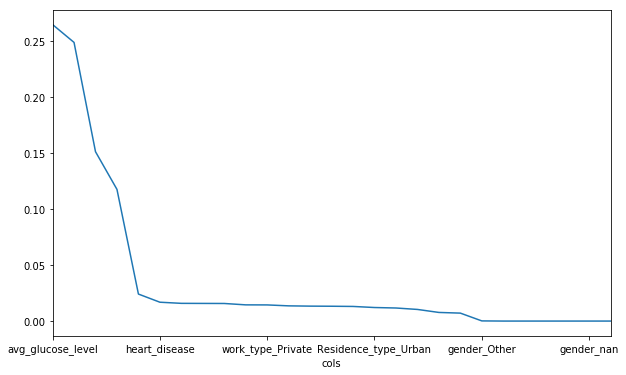

In [57]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [60]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

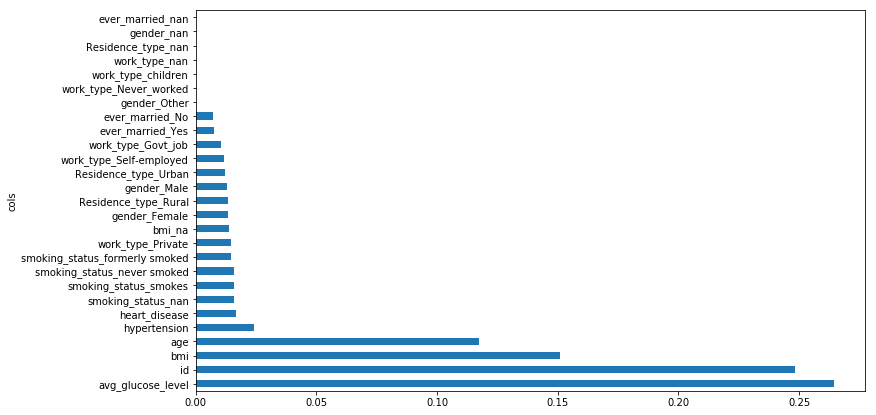

In [61]:
plot_fi(fi[:30]);

In [62]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

20

In [63]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [66]:
m = RandomForestRegressor(n_estimators=1000, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.04797940755508207, 0.1334750619871137, 0.86581438436078428, 0.035020386228543643, 0.012721465229392992]


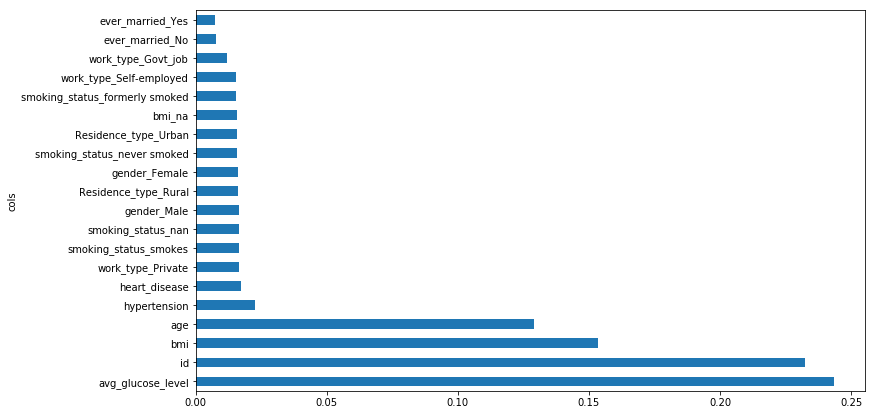

In [67]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [68]:
from scipy.cluster import hierarchy as hc

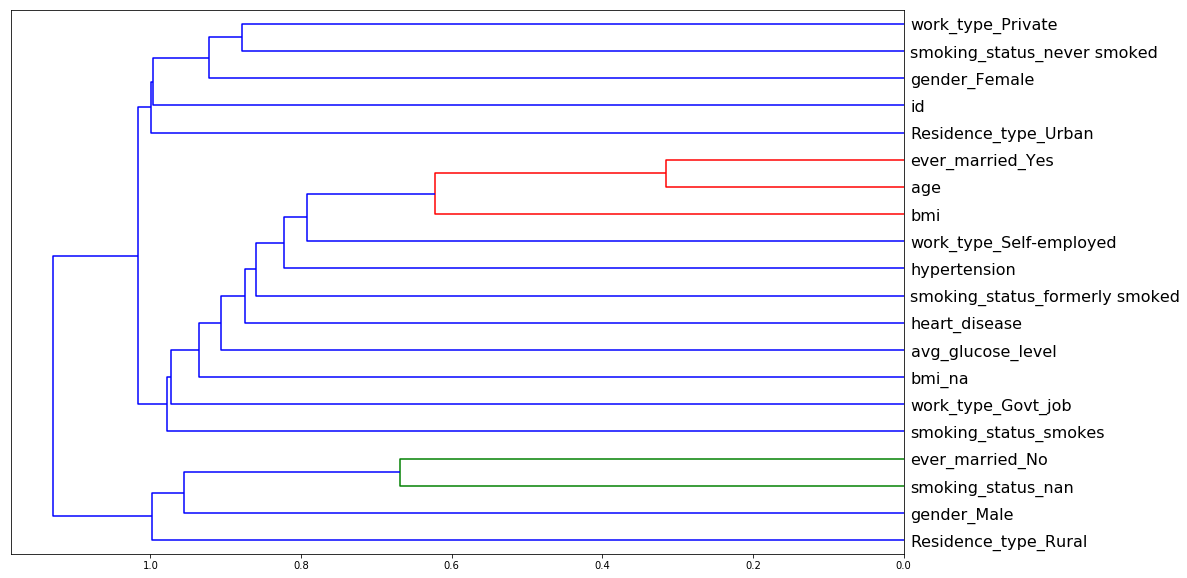

In [69]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [70]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=1000, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [71]:
get_oob(df_keep)

0.039819363310610978

In [204]:
apply_cats(df_test,df_raw)

In [205]:
df_test.shape

(18601, 24)

In [206]:
df.columns

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'impact_encoded_gender', 'impact_encoded_ever_married',
       'impact_encoded_work_type', 'impact_encoded_Residence_type',
       'impact_encoded_smoking_status', 'is_age>40', 'healthy', 'under_weight',
       'over_weight', 'obsese', 'normal_glucose', 'pre_diabetes', 'diabetes',
       'gender_Female', 'gender_Male', 'gender_Other', 'gender_nan',
       'ever_married_No', 'ever_married_Yes', 'ever_married_nan',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'work_type_nan',
       'Residence_type_Rural', 'Residence_type_Urban', 'Residence_type_nan',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'smoking_status_nan'],
      dtype='object')

In [207]:
y_test = y[:18601]

In [208]:
df_test['y'] = y_test

In [209]:
df_test_1, _, _ = proc_df(df_test,'y',na_dict=nas,max_n_cat=20)

In [210]:
df_raw.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,...,impact_encoded_smoking_status,is_age>40,healthy,under_weight,over_weight,obsese,normal_glucose,pre_diabetes,diabetes,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,...,0.018041,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,...,0.017344,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0


In [92]:
df_raw.groupby('gender')['bmi'].mean()

gender
Female    28.745909
Male      28.398452
Other     27.900000
Name: bmi, dtype: float64

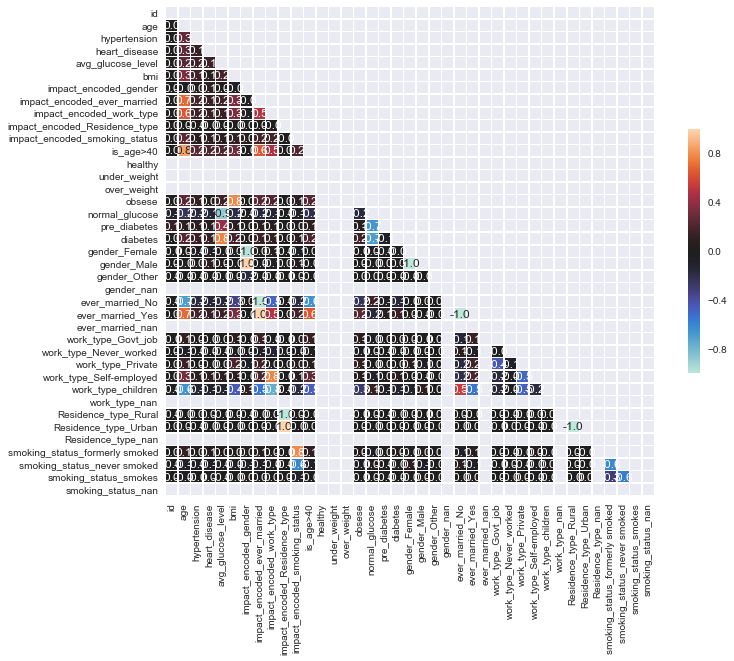

In [211]:
# Calculate the correlation matrix

corr = df.corr(method='pearson')

# Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.1f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [102]:
df_raw.groupby(['work_type','gender'])['age'].describe()

count       mean        std    min    25%   50%  \
work_type     gender                                                      
Govt_job      Female   3312.0  48.769324  15.261100  13.00  38.00  49.0   
              Male     2126.0  49.611947  15.464584  14.00  39.00  50.0   
              Other       2.0  46.000000   9.899495  39.00  42.50  46.0   
Never_worked  Female    101.0  17.514851   5.832005  13.00  15.00  16.0   
              Male       76.0  18.078947   7.477545  13.00  14.00  16.0   
Private       Female  15235.0  44.350574  18.247299   8.00  29.00  43.0   
              Male     9592.0  46.075063  18.498372  13.00  31.00  46.0   
              Other       7.0  38.714286  14.150551  19.00  26.50  46.0   
Self-employed Female   4040.0  58.968564  16.953317  13.00  47.00  61.0   
              Male     2753.0  59.805667  16.539473   7.00  49.00  63.0   
children      Female   2977.0   6.602674   4.511298   0.08   2.00   6.0   
              Male     3177.0   6.787359   4.504071   0.08   2.00   7.0   
              Other       2.0  10.500000   0.707107  10.00  10.25  10.5   

                        75%   max  
work_type     gender               
Govt_job      Female  60.00  82.0  
              Male    61.00  82.0  
              Other   49.50  53.0  
Never_worked  Female  18.00  64.0  
              Male    18.00  59.0  
Private       Female  58.00  82.0  
              Male    60.00  82.0  
              Other   50.00  53.0  
Self-employed Female  74.00  82.0  
              Male    73.00  82.0  
children      Female  10.00  16.0  
              Male    11.00  16.0  
              Other   10.75  11.0

In [113]:
m

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [122]:
m = RandomForestRegressor(n_estimators=1000,
                          n_jobs=-1, oob_score=True)
m.fit(df, y)

ValueError: Number of features of the model must match the input. Model n_features is 27 and input n_features is 20 

In [125]:
preds = m.predict(df_test_1)

In [130]:
categorical_features_indices = []

In [ ]:
#importing library and building model
from catboost import CatBoostClassifier
model=CatBoostClassifier(iterations=1000, depth=10, learning_rate=0.01, loss_function='CrossEntropy',\
                         )
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation))

In [214]:
preds=m.predict(df_test_1)

## xgb

In [5]:
df_raw.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,...,impact_encoded_smoking_status,y,is_age>40,healthy,under_weight,over_weight,obsese,normal_glucose,pre_diabetes,diabetes
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,...,0.018041,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,...,0.017344,0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,...,0.018041,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
df_test.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,...,impact_encoded_Residence_type,impact_encoded_smoking_status,is_age>40,healthy,under_weight,over_weight,obsese,normal_glucose,pre_diabetes,diabetes
0,36306,Male,80.0,0,0,Yes,Private,Urban,83.84,21.1,...,0.017739,0.028568,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,61829,Female,74.0,0,1,Yes,Self-employed,Rural,179.50,26.0,...,0.017643,0.028568,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,14152,Female,14.0,0,0,No,children,Rural,95.16,21.2,...,0.017643,0.018041,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
features = df_raw.columns
numeric_features = []
categorical_features = []

for dtype, feature in zip(df_raw.dtypes, df_raw.columns):
    if dtype == object:
        #print(column)
        #print(train_data[column].describe())
        categorical_features.append(feature)
    else:
        numeric_features.append(feature)
categorical_features

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [44]:
(43400-783)/783

54.427841634738186

In [42]:
np.count_nonzero(y)

783

In [118]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  roc_auc_score

def runXGB(train_X, train_y, test_X, test_y=None, seed_val=1, depth = 10):
    
        params = {}
        params["objective"] = "binary:logistic"
        params['eval_metric'] = 'logloss'
        params["eta"] = 0.01 #0.00334
        params["subsample"] = 0.9
        params["silent"] = 0
        params["max_depth"] = depth
        params["seed"] = seed_val
        params["max_delta_step"] = 4
        params['scale_pos_weight'] = 54.427841634738186 
        #params["gamma"] = 0.5
        num_rounds = 5000 #3600

        plst = list(params.items())
        xgtrain = xgb.DMatrix(train_X, label=train_y)

        if test_y is not None:
                xgtest = xgb.DMatrix(test_X, label=test_y)
                watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
                model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds= 500)
        else:
                xgtest = xgb.DMatrix(test_X)
                #xgtest1 = xgb.DMatrix(test_X1)
                model = xgb.train(plst, xgtrain, num_rounds)

        pred_test_y = model.predict(xgtest)
        
        return pred_test_y, model

In [119]:
df_raw['y'] = y
y = df_raw.y.values;
df_raw.drop('y',axis=1,inplace=True)
train_cats(df_raw);
apply_cats(df_test, df_raw)
df_raw['y'] = y
df_test['y'] =  y[:18601]
df_train , y, nas = proc_df(df_raw, 'y', max_n_cat=20)
df_test , _ , _  = proc_df(df_test, 'y', max_n_cat=20, na_dict= nas)
df_raw.drop('y',axis=1,inplace=True)

In [ ]:
%time preds_xgb, model = runXGB(df_train, y, df_test)

ValueError: feature_names mismatch: ['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'impact_encoded_gender', 'impact_encoded_ever_married', 'impact_encoded_work_type', 'impact_encoded_Residence_type', 'impact_encoded_smoking_status', 'is_age>40', 'healthy', 'under_weight', 'over_weight', 'obsese', 'normal_glucose', 'pre_diabetes', 'diabetes', 'is_age>60', 'is_age>80', 'is_age20&40', 'is_ageless20', 'gender_Female', 'gender_Male', 'gender_Other', 'gender_nan', 'ever_married_No', 'ever_married_Yes', 'ever_married_nan', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'work_type_nan', 'Residence_type_Rural', 'Residence_type_Urban', 'Residence_type_nan', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'smoking_status_nan'] ['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'impact_encoded_gender', 'impact_encoded_ever_married', 'impact_encoded_work_type', 'impact_encoded_Residence_type', 'impact_encoded_smoking_status', 'is_age>40', 'healthy', 'under_weight', 'over_weight', 'obsese', 'normal_glucose', 'pre_diabetes', 'diabetes', 'gender_Female', 'gender_Male', 'gender_Other', 'gender_nan', 'ever_married_No', 'ever_married_Yes', 'ever_married_nan', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'work_type_nan', 'Residence_type_Rural', 'Residence_type_Urban', 'Residence_type_nan', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'smoking_status_nan', 'is_age>60', 'is_age>80', 'is_age20&40', 'is_ageless20']

In [ ]:
xgb.plot_importance(model,max_num_features=20,importance_type='gain')

In [ ]:
len(df_train.columns)

In [ ]:
len(df_test.columns)

In [95]:
df_raw['is_age>60'] = np.where(df_raw['age']>=60,1,0)
df_raw['is_age>80'] = np.where(df_raw['age']>=80,1,0)

df_raw['is_age20&40'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('age>=20 & age<=40').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_ageless20'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('age<20').index
df_raw.iloc[my_query, -1] = 1

df_test['is_age20&40'] = np.zeros(df_test.shape[0])
my_query = df_test.query('age>=20 & age<=40').index
df_test.iloc[my_query, -1] = 1

df_test['is_ageless20'] = np.zeros(df_test.shape[0])
my_query = df_test.query('age<20').index
df_test.iloc[my_query, -1] = 1

In [108]:
df_test['is_age20&40'] = np.zeros(df_test.shape[0])
my_query = df_test.query('age>=20 & age<=40').index
df_test.iloc[my_query, -1] = 1

df_test['is_ageless20'] = np.zeros(df_test.shape[0])
my_query = df_test.query('age<20').index
df_test.iloc[my_query, -1] = 1